## **Land Value Prediction Model**
- Author: Kim Dohwan [@ehghks021203](https://github.com/ehghks021203)
- Date: 2023.09.10. ~
- Description: 
------

## **Overview**
In this project, we developed a predictive model for estimating land value, utilizing the XGBoost algorithm.

### Key Steps:
1. **Load libraries & get data:**

2. **Data Analysis:**
    - In-depth analysis of the collected dataset.

3. **Data Preprocessing:**
    - Handling missing values, encoding categorical variables, and scaling numerical features.

4. **Model Training with XGBoost:**
    - Utilizing the XGBoost algorithm for training the predictive model.

5. **Evaluation and Validation:**
    - Assessing model performance using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

6. **Hyperparameter Tuning:**
    - Fine-tuning model parameters for optimization.

### **Load libraries & get data**

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd
pd.options.display.float_format = "{: .2f}".format

# data visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
sns.set(style="white", context="notebook", palette="deep")

# 그래프 글자 깨짐 문제 해결
fe = fm.FontEntry(
    fname=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf",   # ttf 파일이 저장되어 있는 경로
    name="NanumGothic"
)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정

# Preprocessing 
from sklearn.model_selection import train_test_split

# Data analysis
from scipy.stats import kstest


In [2]:
# Load Train Dataset
DATA_PATH = "./data_full.csv"
df = pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106194 entries, 0 to 106193
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PNU                        106194 non-null  int64  
 1   DealAmount                 106194 non-null  object 
 2   DealMonth                  106194 non-null  int64  
 3   LdCodeNm                   106194 non-null  object 
 4   RegstrSeCodeNm             106194 non-null  object 
 5   Year                       106194 non-null  int64  
 6   LndcgrCodeNm               106194 non-null  object 
 7   LndpclAr                   106194 non-null  float64
 8   PrposAreaNm                106194 non-null  object 
 9   LadUseSittnNm              105232 non-null  object 
 10  TpgrphHgCodeNm             106194 non-null  object 
 11  TpgrphFrmCodeNm            106194 non-null  object 
 12  RoadSideCodeNm             106194 non-null  object 
 13  PblntfPclnd                10

In [3]:
# 실거래가를 면적당 가격으로 환산하지 않음
#df["DealAmount"] = df.DealAmount.str.replace(",", "").astype("float64") * 10000
# 실거래가 데이터 면적당 가격으로 환산 후 실수형 자료형으로 변경
df["DealAmount"] = df.DealAmount.str.replace(",", "").astype("float64") * 10000 / df["LndpclAr"]
# PNU 코드 자료형 object로 변경
df["PNU"] = df["PNU"].astype("str")



In [4]:
df.insert(loc=1,column="Sido",value=df["PNU"].str.slice(0, 2).astype("object"))
df.insert(loc=2,column="Sigungu",value=df["PNU"].str.slice(2, 5).astype("object"))
df.insert(loc=3,column="Eupmyeondong",value=df["PNU"].str.slice(5, 8).astype("object"))
df.insert(loc=4,column="Ri",value=df["PNU"].str.slice(8, 10).astype("object"))

In [5]:
categorical = [var for var in df.columns if df[var].dtype=='O']
df[categorical].head()

,PNU,Sido,Sigungu,Eupmyeondong,Ri,LdCodeNm,RegstrSeCodeNm,LndcgrCodeNm,PrposAreaNm,LadUseSittnNm,TpgrphHgCodeNm,TpgrphFrmCodeNm,RoadSideCodeNm,PrposAreaDstrcCodeNm
0,2611012000101450037,26,110,120,00,부산광역시 중구 보수동1가,일반,대,일반상업지역,도로등,급경사,삼각형,세로한면(불),"상대보호구역(포함),가축사육제한구역(포함),제3종일반주거지역(포함),용도구역기타(저..."
1,2611012100101020000,26,110,121,00,부산광역시 중구 보수동2가,일반,대,일반상업지역,주상용,평지,삼각형,소로각지,"상대보호구역(포함),가축사육제한구역(포함),가로구역별 최고높이 제한지역(저촉),일반..."
2,2611010700100360027,26,110,107,00,부산광역시 중구 중앙동4가,일반,대,일반상업지역,상업나지,평지,세로장방,중로각지,"항만구역(포함),가축사육제한구역(포함),준공업지역(접함),건축용도지역기타(접함),지..."
3,2611010700100360027,26,110,107,00,부산광역시 중구 중앙동4가,일반,대,일반상업지역,상업나지,평지,세로장방,중로각지,"항만구역(포함),가축사육제한구역(포함),준공업지역(접함),건축용도지역기타(접함),지..."
4,2611010700100340000,26,110,107,00,부산광역시 중구 중앙동4가,일반,대,일반상업지역,상업나지,평지,세로장방,중로각지,"항만구역(포함),가축사육제한구역(포함),준공업지역(접함),건축용도지역기타(접함),지..."


In [6]:
# 필지가 일반이거나 산인 데이터만 남기기
df = pd.concat([df[df["RegstrSeCodeNm"] == "일반"], df[df["RegstrSeCodeNm"] == "산"]])

In [7]:
#df = df[df["Sido"] == "41"]
#df = df[df["Sido"] == "46"]
df

,PNU,Sido,Sigungu,Eupmyeondong,Ri,DealAmount,DealMonth,LdCodeNm,RegstrSeCodeNm,Year,LndcgrCodeNm,LndpclAr,PrposAreaNm,LadUseSittnNm,TpgrphHgCodeNm,TpgrphFrmCodeNm,RoadSideCodeNm,PblntfPclnd,Tot_ppltn,Avg_age,Ppltn_dnsty,Aged_child_idx,Oldage_suprt_per,Juv_suprt_per,Tot_family,Avg_fmember_cnt,Tot_house,Corp_cnt,Tot_worker,ChangePricePercent,ChangePricePercentTotal,ChangePricePercentAverage,PrposAreaDstrcCodeNm
0,2611012000101450037,26,110,120,00,1820075.76,1,부산광역시 중구 보수동1가,일반,2021,대,26.40,일반상업지역,도로등,급경사,삼각형,세로한면(불),266600,9852.00,48.60,23832.40,431.00,36.90,8.60,5186.00,1.90,4029.00,1008.00,3133.00,0.20,2.32,0.19,"상대보호구역(포함),가축사육제한구역(포함),제3종일반주거지역(포함),용도구역기타(저..."
1,2611012100101020000,26,110,121,00,7070042.75,3,부산광역시 중구 보수동2가,일반,2021,대,304.10,일반상업지역,주상용,평지,삼각형,소로각지,2486000,9852.00,48.60,23832.40,431.00,36.90,8.60,5186.00,1.90,4029.00,1008.00,3133.00,0.20,2.32,0.19,"상대보호구역(포함),가축사육제한구역(포함),가로구역별 최고높이 제한지역(저촉),일반..."
2,2611010700100360027,26,110,107,00,7027897.00,4,부산광역시 중구 중앙동4가,일반,2021,대,186.40,일반상업지역,상업나지,평지,세로장방,중로각지,5960000,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0.02,3.35,0.28,"항만구역(포함),가축사육제한구역(포함),준공업지역(접함),건축용도지역기타(접함),지..."
3,2611010700100360027,26,110,107,00,7081545.06,4,부산광역시 중구 중앙동4가,일반,2021,대,186.40,일반상업지역,상업나지,평지,세로장방,중로각지,5960000,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0.02,3.35,0.28,"항만구역(포함),가축사육제한구역(포함),준공업지역(접함),건축용도지역기타(접함),지..."
4,2611010700100340000,26,110,107,00,9984639.02,4,부산광역시 중구 중앙동4가,일반,2021,대,130.20,일반상업지역,상업나지,평지,세로장방,중로각지,5960000,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0.02,3.35,0.28,"항만구역(포함),가축사육제한구역(포함),준공업지역(접함),건축용도지역기타(접함),지..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103623,1159010200200130016,11,590,102,00,1000000.00,4,서울특별시 동작구 상도동,산,2021,도로,16.00,제2종일반주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,1993000,43629.00,40.60,29444.10,148.30,19.40,13.10,20166.00,2.10,14697.00,2514.00,9261.00,0.57,4.77,0.40,"대공방어협조구역(포함),상대보호구역(포함),(한강)폐기물매립시설 설치제한지역(포함)..."
105409,3171034021200030000,31,710,340,21,69288.96,1,울산광역시 울주군 웅촌면 초천리,산,2021,임야,661.00,자연녹지지역,자연림,급경사,삼각형,세로한면(가),8560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,1.89,0.16,"공장설립승인지역(포함),가축사육제한구역(포함),생산관리지역(저촉),가축사육제한구역(..."
105410,3171034021200030000,31,710,340,21,69288.96,1,울산광역시 울주군 웅촌면 초천리,산,2021,임야,661.00,자연녹지지역,자연림,급경사,삼각형,세로한면(가),8560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,1.89,0.16,"공장설립승인지역(포함),가축사육제한구역(포함),생산관리지역(저촉),가축사육제한구역(..."
105908,3171034023200130010,31,710,340,23,94339.62,9,울산광역시 울주군 웅촌면 곡천리,산,2021,임야,212.00,자연녹지지역,자연림,완경사,삼각형,세로한면(가),19700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,1.89,0.16,"공장설립승인지역(포함),도시지역(포함),도로구역(접함),자연녹지지역(포함),가축사육..."


In [8]:
# 예측 시 음수 가격이 나오지 않도록 하기 위한 작업
df["DealAmount"] = df["DealAmount"] ** 0.5
df["PblntfPclnd"] = df["PblntfPclnd"] ** 0.5

df1 = df.copy()
df1["difference"] = abs(df1["DealAmount"]/df1["PblntfPclnd"])

<Axes: xlabel='difference'>

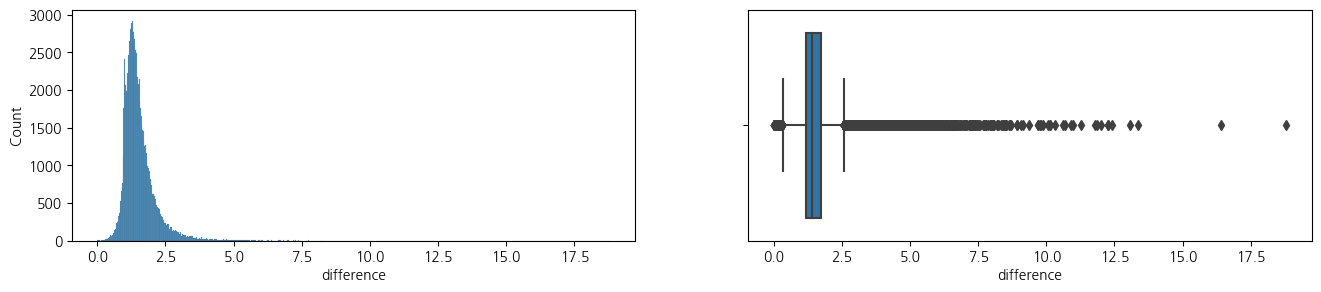

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

sns.histplot(x=df1["difference"], ax=axes[0])
sns.boxplot(x=df1["difference"], ax=axes[1])

In [10]:
df1["difference"].describe()

count    106159.00
mean          1.55
std           0.65
min           0.00
25%           1.17
50%           1.40
75%           1.74
max          18.80
Name: difference, dtype: float64

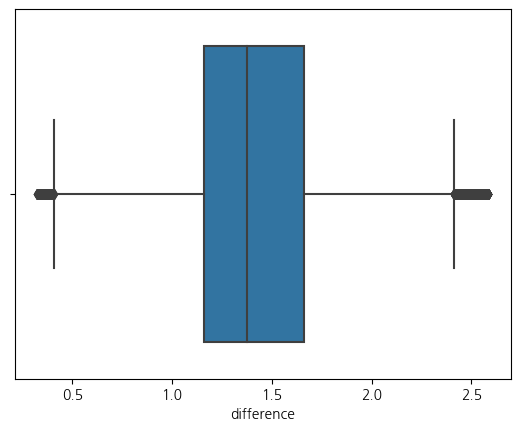

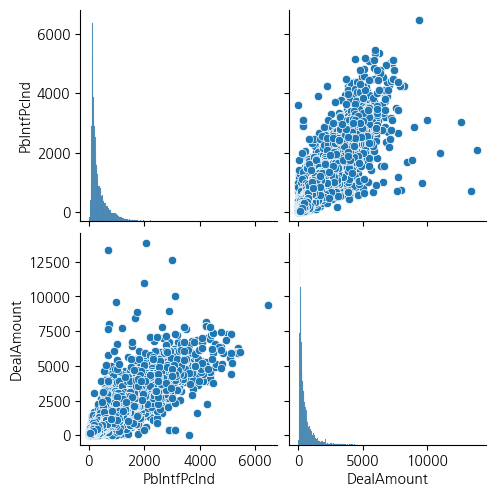

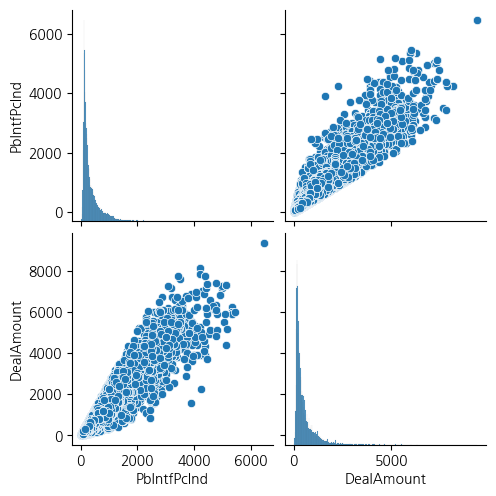

In [11]:
df1["difference"] = abs(df1["DealAmount"]/df1["PblntfPclnd"])

weight = 1.5

quantile_25 = np.percentile(df1["difference"].values, 25)
quantile_75 = np.percentile(df1["difference"].values, 75)

IQR = quantile_75 - quantile_25
IQR_weight = IQR*weight
  
lowest = quantile_25 - IQR_weight
highest = quantile_75 + IQR_weight

df1 = df1[df1["difference"].between(lowest, highest)]
sns.boxplot(x=df1["difference"])
df1 = df1.drop(["difference"], axis=1)

sns.pairplot(df, vars=["PblntfPclnd", "DealAmount"])
sns.pairplot(df1, vars=["PblntfPclnd", "DealAmount"])
plt.show()

[Text(0, 0, '세로한면(불)'),
 Text(1, 0, '소로각지'),
 Text(2, 0, '중로각지'),
 Text(3, 0, '소로한면'),
 Text(4, 0, '세로한면(가)'),
 Text(5, 0, '광대세각'),
 Text(6, 0, '지정되지않음'),
 Text(7, 0, '중로한면'),
 Text(8, 0, '광대로한면'),
 Text(9, 0, '세로각지(불)'),
 Text(10, 0, '맹지'),
 Text(11, 0, '세로각지(가)'),
 Text(12, 0, '광대소각')]

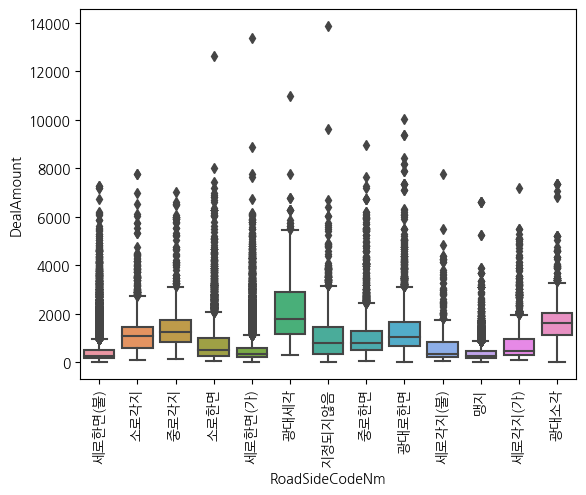

In [12]:
ax = sns.boxplot(x=df["RoadSideCodeNm"], y=df["DealAmount"])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Text(0.5, 1.0, '도로접면')

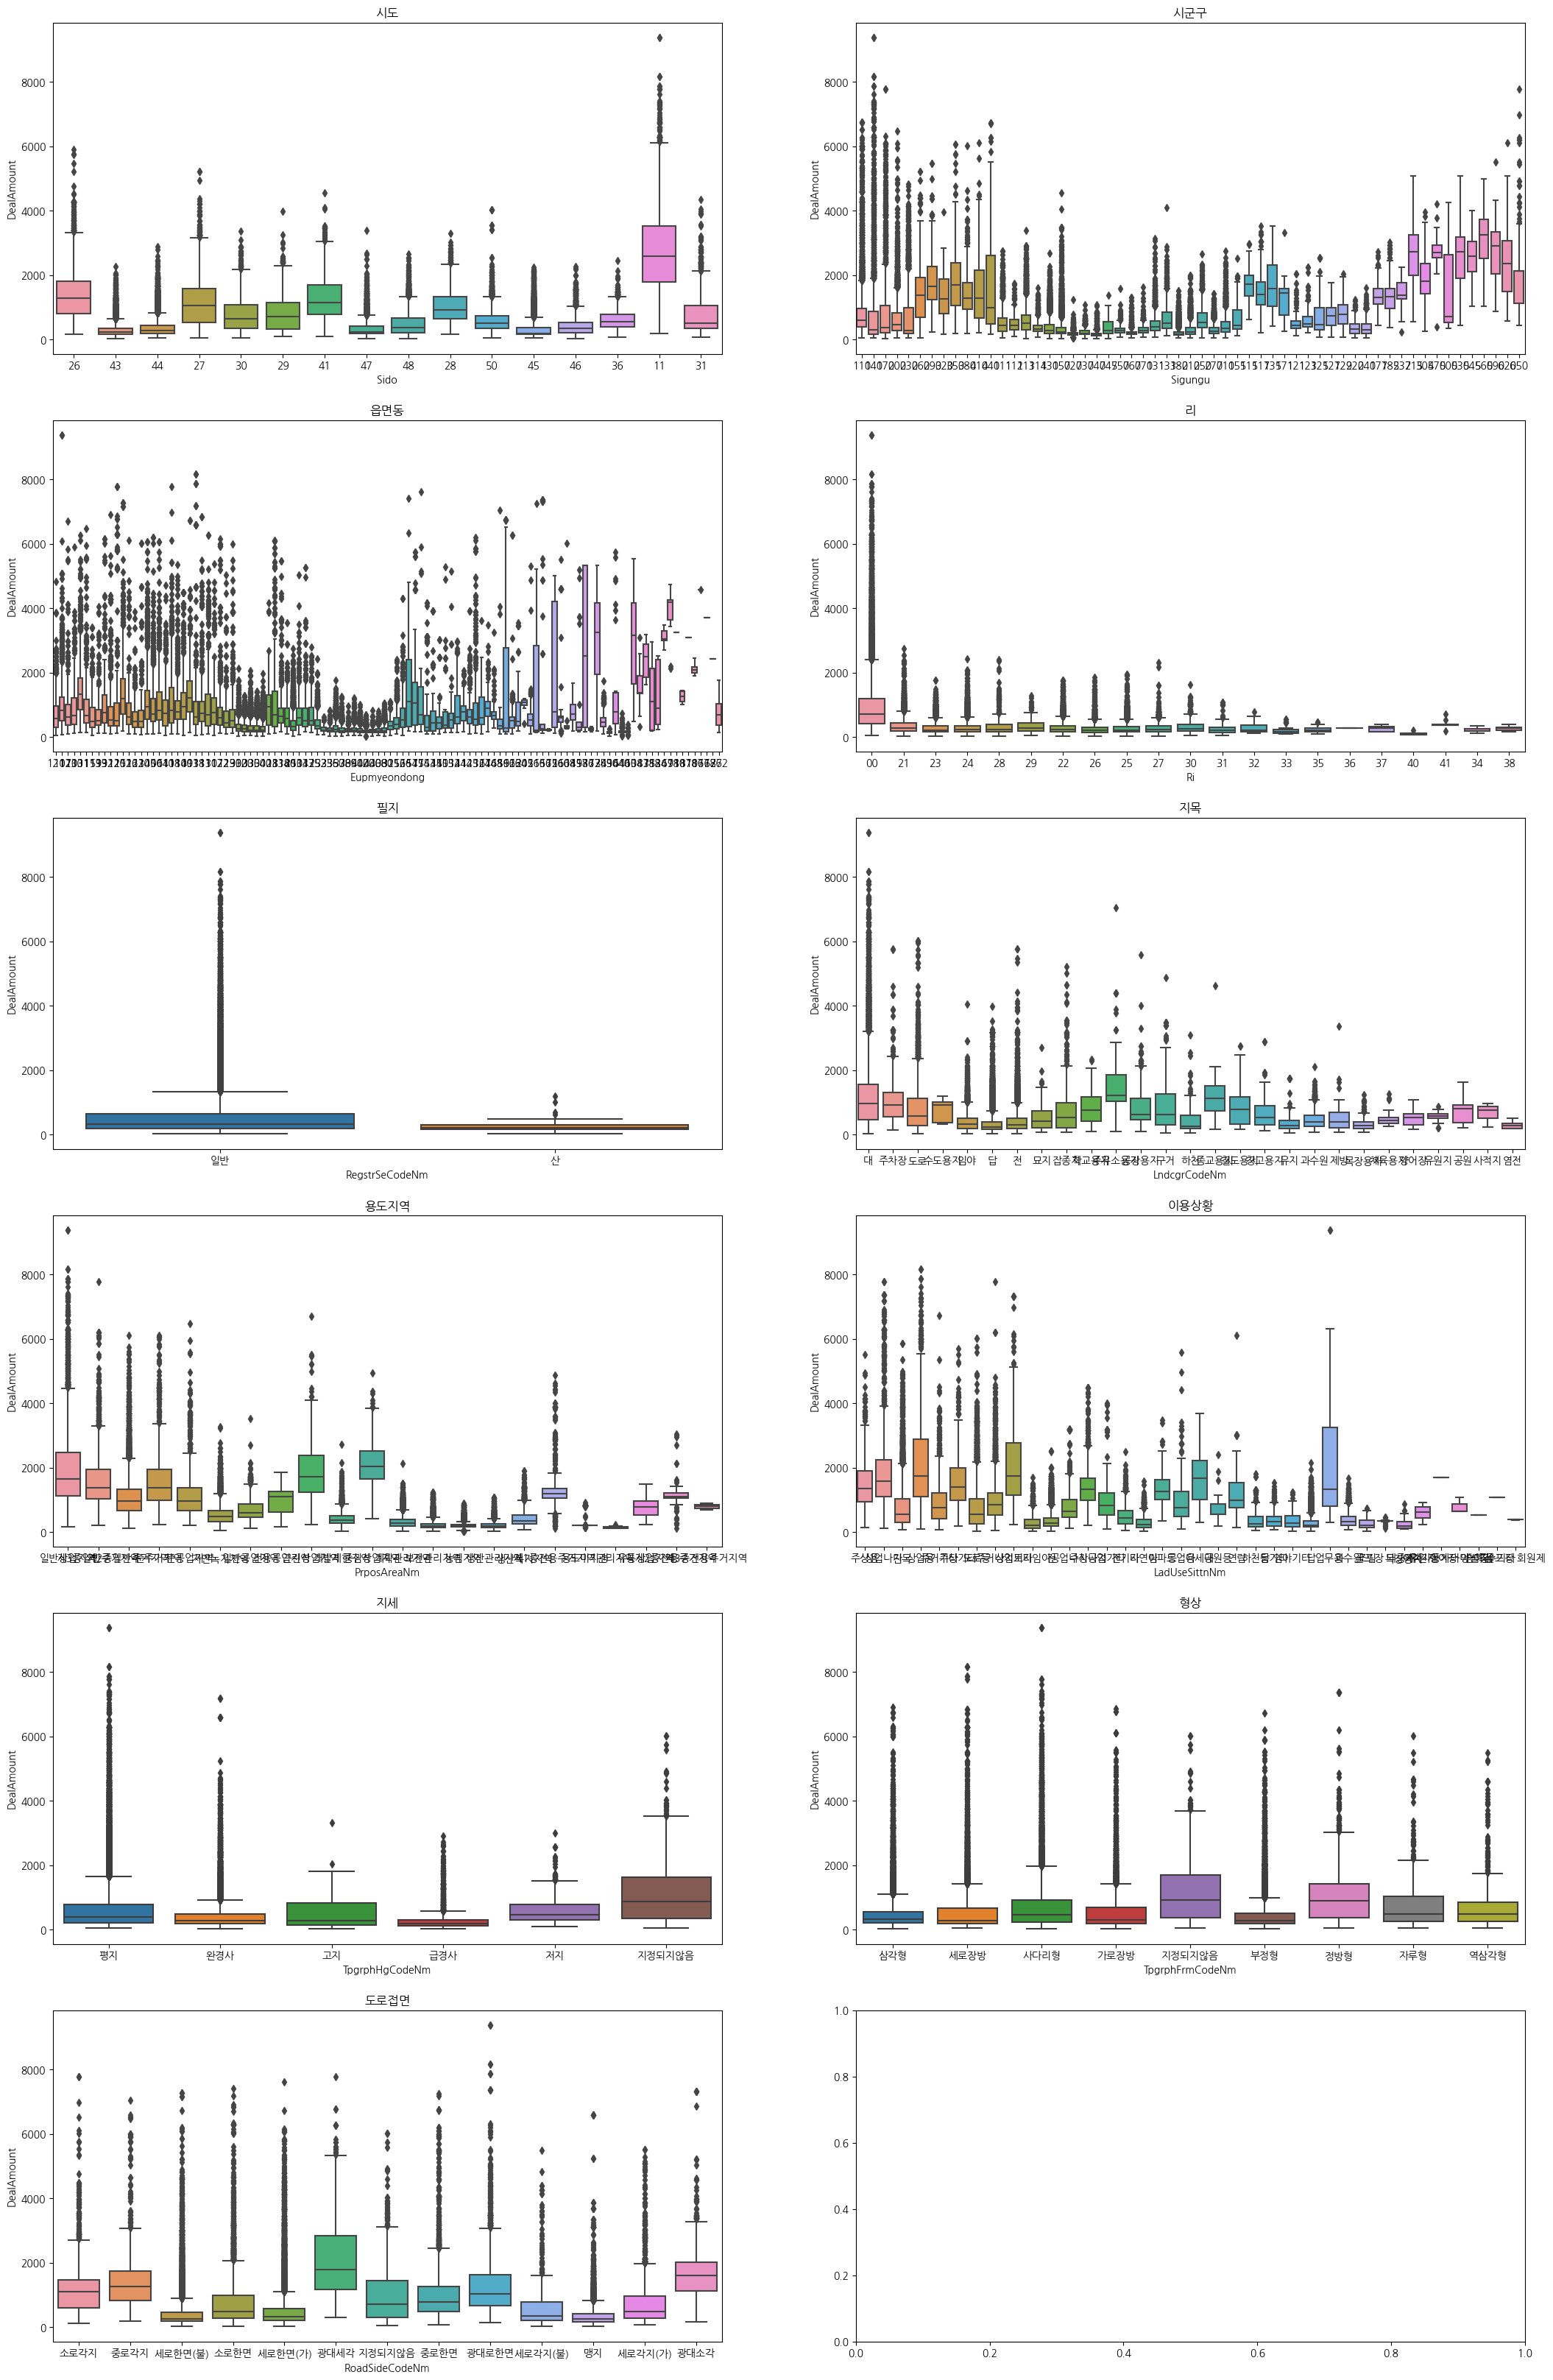

In [13]:
df = df1

fig, axes = plt.subplots(6, 2, figsize=(25, 15))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=2.2)

sns.boxplot(x=df["Sido"], y=df["DealAmount"], ax=axes[0][0]).set_title("시도")
sns.boxplot(x=df["Sigungu"], y=df["DealAmount"], ax=axes[0][1]).set_title("시군구")

sns.boxplot(x=df["Eupmyeondong"], y=df["DealAmount"], ax=axes[1][0]).set_title("읍면동")
sns.boxplot(x=df["Ri"], y=df["DealAmount"], ax=axes[1][1]).set_title("리")

sns.boxplot(x=df["RegstrSeCodeNm"], y=df["DealAmount"], ax=axes[2][0]).set_title("필지")
sns.boxplot(x=df["LndcgrCodeNm"], y=df["DealAmount"], ax=axes[2][1]).set_title("지목")

sns.boxplot(x=df["PrposAreaNm"], y=df["DealAmount"], ax=axes[3][0]).set_title("용도지역")
sns.boxplot(x=df["LadUseSittnNm"], y=df["DealAmount"], ax=axes[3][1]).set_title("이용상황")

sns.boxplot(x=df["TpgrphHgCodeNm"], y=df["DealAmount"], ax=axes[4][0]).set_title("지세")
sns.boxplot(x=df["TpgrphFrmCodeNm"], y=df["DealAmount"], ax=axes[4][1]).set_title("형상")

sns.boxplot(x=df["RoadSideCodeNm"], y=df["DealAmount"], ax=axes[5][0]).set_title("도로접면")

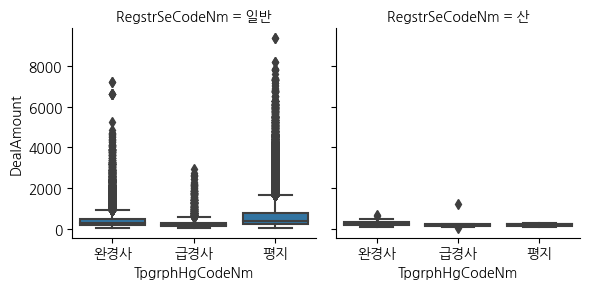

In [14]:
facet = sns.FacetGrid(data=df, col="RegstrSeCodeNm")
facet.map(sns.boxplot, "TpgrphHgCodeNm", "DealAmount", order=["완경사", "급경사", "평지"])

## 연속형 변수 추출

In [15]:
numerical = [var for var in df.columns if df[var].dtype!="O"]
df[numerical].head()

,DealAmount,DealMonth,Year,LndpclAr,PblntfPclnd,Tot_ppltn,Avg_age,Ppltn_dnsty,Aged_child_idx,Oldage_suprt_per,Juv_suprt_per,Tot_family,Avg_fmember_cnt,Tot_house,Corp_cnt,Tot_worker,ChangePricePercent,ChangePricePercentTotal,ChangePricePercentAverage
1,2658.96,3,2021,304.10,1576.71,9852.00,48.60,23832.40,431.00,36.90,8.60,5186.00,1.90,4029.00,1008.00,3133.00,0.20,2.32,0.19
2,2651.02,4,2021,186.40,2441.31,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0.02,3.35,0.28
3,2661.12,4,2021,186.40,2441.31,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0.02,3.35,0.28
4,3159.85,4,2021,130.20,2441.31,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0.02,3.35,0.28
5,1408.59,4,2021,12.60,760.72,9852.00,48.60,23832.40,431.00,36.90,8.60,5186.00,1.90,4029.00,1008.00,3133.00,0.20,2.32,0.19


In [16]:
print(df[numerical].isnull().sum())        # Check the missing value
df = df.dropna()
print(df[numerical].isnull().sum())        # Check the missing value

DealAmount                       0
DealMonth                        0
Year                             0
LndpclAr                         0
PblntfPclnd                      0
Tot_ppltn                    12058
Avg_age                      12058
Ppltn_dnsty                  12058
Aged_child_idx               12058
Oldage_suprt_per             12058
Juv_suprt_per                12058
Tot_family                   12058
Avg_fmember_cnt              12058
Tot_house                    12058
Corp_cnt                     12058
Tot_worker                   12058
ChangePricePercent              19
ChangePricePercentTotal         19
ChangePricePercentAverage       19
dtype: int64
DealAmount                   0
DealMonth                    0
Year                         0
LndpclAr                     0
PblntfPclnd                  0
Tot_ppltn                    0
Avg_age                      0
Ppltn_dnsty                  0
Aged_child_idx               0
Oldage_suprt_per             0
Juv_suprt_pe

In [17]:
for n in numerical:
    ks_test = kstest(df[n], "norm", args=(df[n].mean(), df[n].var()**0.5))
    print("{:18s}| statistic = {:.8f}, pvalue = {:.8f}".format(n, ks_test.statistic, ks_test.pvalue))

DealAmount        | statistic = 0.20702568, pvalue = 0.00000000
DealMonth         | statistic = 0.10890323, pvalue = 0.00000000
Year              | statistic = 0.36212490, pvalue = 0.00000000
LndpclAr          | statistic = 0.31246098, pvalue = 0.00000000
PblntfPclnd       | statistic = 0.20208891, pvalue = 0.00000000
Tot_ppltn         | statistic = 0.17762932, pvalue = 0.00000000
Avg_age           | statistic = 0.10061501, pvalue = 0.00000000
Ppltn_dnsty       | statistic = 0.29160889, pvalue = 0.00000000
Aged_child_idx    | statistic = 0.14825547, pvalue = 0.00000000
Oldage_suprt_per  | statistic = 0.14317189, pvalue = 0.00000000
Juv_suprt_per     | statistic = 0.12398737, pvalue = 0.00000000
Tot_family        | statistic = 0.15691605, pvalue = 0.00000000
Avg_fmember_cnt   | statistic = 0.15419010, pvalue = 0.00000000
Tot_house         | statistic = 0.15951278, pvalue = 0.00000000
Corp_cnt          | statistic = 0.16752064, pvalue = 0.00000000
Tot_worker        | statistic = 0.213696

In [18]:
print(df["PblntfPclnd"].describe())
print(df["DealAmount"].describe())

count    52949.00
mean       494.92
std        521.46
min         11.87
25%        162.79
50%        306.43
75%        635.14
max       6470.70
Name: PblntfPclnd, dtype: float64
count    52949.00
mean       713.70
std        789.64
min         20.76
25%        219.26
50%        433.24
75%        913.57
max       9378.50
Name: DealAmount, dtype: float64


/usr/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/home/students/cs/202120990/.local/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/students/cs/202120990/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


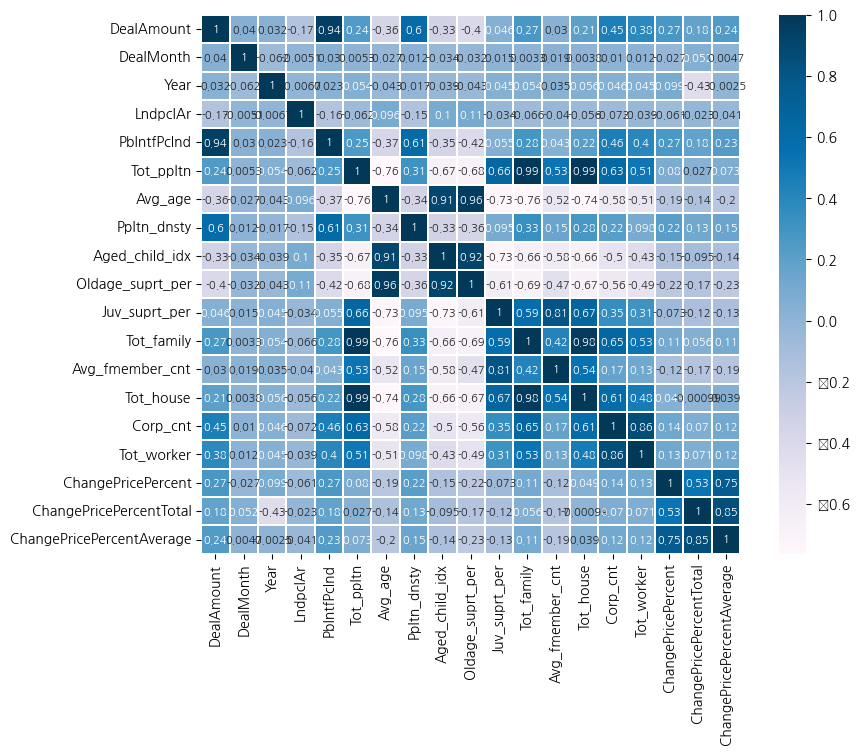

In [19]:
corr = df[numerical].corr(method="pearson")
colormap = plt.cm.PuBu
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    corr, linewidths = 0.1, 
    vmax = 1.0,
    square = True, 
    cmap = colormap, 
    linecolor = "white", 
    annot = True, 
    annot_kws = {"size" : 8}
)

In [20]:
df_ohe = df.reset_index()
df_ohe.drop(["index", "PNU", "LdCodeNm", "PrposAreaDstrcCodeNm", "Sigungu", "Eupmyeondong", "Ri", "LndpclAr", "ChangePricePercent",
            "ChangePricePercentTotal", "ChangePricePercentAverage"], axis=1, inplace=True)
#df_ohe.drop(["PblntfPclnd"], axis=1, inplace=True)
df_ohe = pd.get_dummies(data=df_ohe, columns=["Sido"])
df_ohe = pd.get_dummies(data=df_ohe, columns=["RegstrSeCodeNm", "LndcgrCodeNm", "PrposAreaNm", 
                                              "LadUseSittnNm", "TpgrphHgCodeNm", "TpgrphFrmCodeNm", 
                                              "RoadSideCodeNm"])

In [21]:
print(df_ohe.columns)

Index(['DealAmount', 'DealMonth', 'Year', 'PblntfPclnd', 'Tot_ppltn',
       'Avg_age', 'Ppltn_dnsty', 'Aged_child_idx', 'Oldage_suprt_per',
       'Juv_suprt_per', 'Tot_family', 'Avg_fmember_cnt', 'Tot_house',
       'Corp_cnt', 'Tot_worker', 'Sido_11', 'Sido_26', 'Sido_27', 'Sido_28',
       'Sido_29', 'Sido_30', 'Sido_31', 'Sido_36', 'Sido_41', 'Sido_44',
       'Sido_45', 'Sido_46', 'RegstrSeCodeNm_산', 'RegstrSeCodeNm_일반',
       'LndcgrCodeNm_공원', 'LndcgrCodeNm_공장용지', 'LndcgrCodeNm_과수원',
       'LndcgrCodeNm_구거', 'LndcgrCodeNm_답', 'LndcgrCodeNm_대',
       'LndcgrCodeNm_도로', 'LndcgrCodeNm_목장용지', 'LndcgrCodeNm_묘지',
       'LndcgrCodeNm_사적지', 'LndcgrCodeNm_수도용지', 'LndcgrCodeNm_양어장',
       'LndcgrCodeNm_염전', 'LndcgrCodeNm_유원지', 'LndcgrCodeNm_유지',
       'LndcgrCodeNm_임야', 'LndcgrCodeNm_잡종지', 'LndcgrCodeNm_전',
       'LndcgrCodeNm_제방', 'LndcgrCodeNm_종교용지', 'LndcgrCodeNm_주유소용지',
       'LndcgrCodeNm_주차장', 'LndcgrCodeNm_창고용지', 'LndcgrCodeNm_철도용지',
       'LndcgrCodeNm_체육용지', 'LndcgrCode

In [22]:
df_all = df_ohe.loc[:,df_ohe.columns]

In [23]:
#x = df_numeric.drop(["DealAmount"], axis=1)
#y = df_numeric["DealAmount"]

#x = df_categorical.drop(["DealAmount"], axis=1)
#y = df_categorical["DealAmount"]

x = df_all.drop(["DealAmount"], axis=1)
y = df_all["DealAmount"]

#x = df_some.drop(["DealAmount"], axis=1)
#y = df_some["DealAmount"]

x.head()

,DealMonth,Year,PblntfPclnd,Tot_ppltn,Avg_age,Ppltn_dnsty,Aged_child_idx,Oldage_suprt_per,Juv_suprt_per,Tot_family,Avg_fmember_cnt,Tot_house,Corp_cnt,Tot_worker,Sido_11,Sido_26,Sido_27,Sido_28,Sido_29,Sido_30,Sido_31,Sido_36,Sido_41,Sido_44,Sido_45,Sido_46,RegstrSeCodeNm_산,RegstrSeCodeNm_일반,LndcgrCodeNm_공원,LndcgrCodeNm_공장용지,LndcgrCodeNm_과수원,LndcgrCodeNm_구거,LndcgrCodeNm_답,LndcgrCodeNm_대,LndcgrCodeNm_도로,LndcgrCodeNm_목장용지,LndcgrCodeNm_묘지,LndcgrCodeNm_사적지,LndcgrCodeNm_수도용지,LndcgrCodeNm_양어장,LndcgrCodeNm_염전,LndcgrCodeNm_유원지,LndcgrCodeNm_유지,LndcgrCodeNm_임야,LndcgrCodeNm_잡종지,LndcgrCodeNm_전,LndcgrCodeNm_제방,LndcgrCodeNm_종교용지,LndcgrCodeNm_주유소용지,LndcgrCodeNm_주차장,LndcgrCodeNm_창고용지,LndcgrCodeNm_철도용지,LndcgrCodeNm_체육용지,LndcgrCodeNm_하천,LndcgrCodeNm_학교용지,PrposAreaNm_개발제한구역,PrposAreaNm_계획관리지역,PrposAreaNm_관리지역,PrposAreaNm_근린상업지역,PrposAreaNm_농림지역,PrposAreaNm_보전관리지역,PrposAreaNm_생산관리지역,PrposAreaNm_생산녹지지역,PrposAreaNm_용도미지정,PrposAreaNm_유통상업지역,PrposAreaNm_일반공업지역,PrposAreaNm_일반상업지역,PrposAreaNm_자연녹지지역,PrposAreaNm_전용공업지역,PrposAreaNm_제1종전용주거지역,PrposAreaNm_제2종일반주거지역,PrposAreaNm_제2종전용주거지역,PrposAreaNm_제3종일반주거지역,PrposAreaNm_준공업지역,PrposAreaNm_준주거지역,PrposAreaNm_중심상업지역,LadUseSittnNm_골프장 대중제,LadUseSittnNm_골프장 회원제,LadUseSittnNm_공업기타,LadUseSittnNm_공업나지,LadUseSittnNm_공업용,LadUseSittnNm_공원등,LadUseSittnNm_과수원,LadUseSittnNm_다세대,LadUseSittnNm_단독,LadUseSittnNm_답,LadUseSittnNm_답기타,LadUseSittnNm_도로등,LadUseSittnNm_목장용지,LadUseSittnNm_상업기타,LadUseSittnNm_상업나지,LadUseSittnNm_상업용,LadUseSittnNm_아파트,LadUseSittnNm_업무용,LadUseSittnNm_여객자동차터미널,LadUseSittnNm_연립,LadUseSittnNm_유원지,LadUseSittnNm_임야기타,LadUseSittnNm_자연림,LadUseSittnNm_전,LadUseSittnNm_전기타,LadUseSittnNm_조림,LadUseSittnNm_주거기타,LadUseSittnNm_주거나지,LadUseSittnNm_주상기타,LadUseSittnNm_주상나지,LadUseSittnNm_주상용,LadUseSittnNm_토지임야,LadUseSittnNm_하천등,TpgrphHgCodeNm_고지,TpgrphHgCodeNm_급경사,TpgrphHgCodeNm_완경사,TpgrphHgCodeNm_저지,TpgrphHgCodeNm_지정되지않음,TpgrphHgCodeNm_평지,TpgrphFrmCodeNm_가로장방,TpgrphFrmCodeNm_부정형,TpgrphFrmCodeNm_사다리형,TpgrphFrmCodeNm_삼각형,TpgrphFrmCodeNm_세로장방,TpgrphFrmCodeNm_역삼각형,TpgrphFrmCodeNm_자루형,TpgrphFrmCodeNm_정방형,TpgrphFrmCodeNm_지정되지않음,RoadSideCodeNm_광대로한면,RoadSideCodeNm_광대세각,RoadSideCodeNm_광대소각,RoadSideCodeNm_맹지,RoadSideCodeNm_세로각지(가),RoadSideCodeNm_세로각지(불),RoadSideCodeNm_세로한면(가),RoadSideCodeNm_세로한면(불),RoadSideCodeNm_소로각지,RoadSideCodeNm_소로한면,RoadSideCodeNm_중로각지,RoadSideCodeNm_중로한면,RoadSideCodeNm_지정되지않음
0,3,2021,1576.71,9852.00,48.60,23832.40,431.00,36.90,8.60,5186.00,1.90,4029.00,1008.00,3133.00,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,4,2021,2441.31,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,4,2021,2441.31,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,2021,2441.31,2837.00,51.70,3747.50,1445.30,50.10,3.50,1493.00,1.50,457.00,7985.00,37661.00,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,2021,760.72,9852.00,48.60,23832.40,431.00,36.90,8.60,5186.00,1.90,4029.00,1008.00,3133.00,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1

In [24]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 0)
print('Train Dataset:', train_x.shape, '\nTest Dataset:', test_x.shape)

Train Dataset: (37064, 137) 
Test Dataset: (15885, 137)


In [25]:
train_y = train_y.to_numpy().astype(int)
test_y = test_y.to_numpy().astype(int)
#print('Train:', train_y, '\nTest:', test_y)

In [26]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

parameter = {
    'learning_rate':0.22,
    'n_estimators':350,
    'max_depth':9,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.91,
    'colsample_bytree':0.89,
    'lambda':10,
    'alpha':5,
    'eval_metric':'rmse',
    'seed':0
}
    
model = XGBRegressor(
    tree_method = 'gpu_hist',
    gpu_id = 0,
    importance_type = 'gain',
    learning_rate = parameter['learning_rate'],
    n_estimators = parameter['n_estimators'], 
    max_depth = parameter['max_depth'],
    min_child_weight = parameter['min_child_weight'],
    gamma = parameter['gamma'],
    subsample = parameter['subsample'],
    colsample_bytree = parameter['colsample_bytree'],
    reg_lambda = parameter['lambda'],
    alpha = parameter['alpha'],
    eval_metric = parameter['eval_metric'],
    seed = parameter['seed']
)

In [27]:
model.fit(train_x, train_y)
relation_square = model.score(train_x, train_y)

In [28]:
print('결정계수 : ', relation_square)

결정계수 :  0.9942152116432506


In [29]:
sido = [26, 43, 44, 27, 30, 29, 41, 47, 48, 28, 50, 45, 46, 36, 11, 31]

if 1 == 1:
    result = pd.DataFrame(columns = ["sido", "pred", "real"])
    for i in sido:
        if "Sido_" + str(i) not in test_x:
            continue
        predict_y = model.predict(test_x[test_x["Sido_" + str(i)] == 1])
        res = pd.DataFrame({"sido":i, "pred" : predict_y ** 2, "real" : test_y[test_x["Sido_" + str(i)] == 1] ** 2})
        print(str(i), ') RMSE score:', mean_squared_error(test_y[test_x["Sido_" + str(i)] == 1] ** 2, predict_y ** 2) ** 0.5)
        result = pd.concat([result, res])

    #result = pd.DataFrame({"sido": 'pred' : predict_y ** 2, 'real' : test_y ** 2})
    #print('RMSE score:', mean_squared_error(test_y ** 2, predict_y ** 2) ** 0.5)
    result['ratio(%)'] = (abs(result['pred'] - result['real']) / result['real']) * 100

else:
    predict_y = model.predict(test_x)

    result = pd.DataFrame({'pred' : predict_y ** 2, 'real' : test_y ** 2})
    print('RMSE score:', mean_squared_error(test_y ** 2, predict_y ** 2) ** 0.5)

    for i in range(len(result['real'])):
        if result['real'][i] == 0:
            if result['pred'][i] == 0:
                result['pred'][i] = 1
            result['real'][i] = 1
    result['ratio(%)'] = (abs(result['pred'] - result['real']) / result['real']) * 100
    


26 ) RMSE score: 1434623.8147153906
44 ) RMSE score: 148259.65220844606
27 ) RMSE score: 1287942.157630705
30 ) RMSE score: 412374.5782597676
29 ) RMSE score: 477937.95692345174
41 ) RMSE score: 1017627.1864432718
28 ) RMSE score: 544250.5215795276
45 ) RMSE score: 142889.68451606506
46 ) RMSE score: 192580.10766532953
36 ) RMSE score: 200998.8961893337
11 ) RMSE score: 3857763.487305907
31 ) RMSE score: 776750.3179126533


In [30]:
result

,sido,pred,real,ratio(%)
0,26,885011.69,599076,47.73
1,26,1495262.38,1552516,3.69
2,26,248279.00,435600,43.00
3,26,126860.60,220900,42.57
4,26,331318.91,302500,9.53
...,...,...,...,...
401,31,4166488.25,2712609,53.60
402,31,646500.31,715716,9.67
403,31,335248.06,186624,79.64
404,31,2002711.75,3701776,45.90


<Axes: xlabel='ratio(%)', ylabel='Density'>

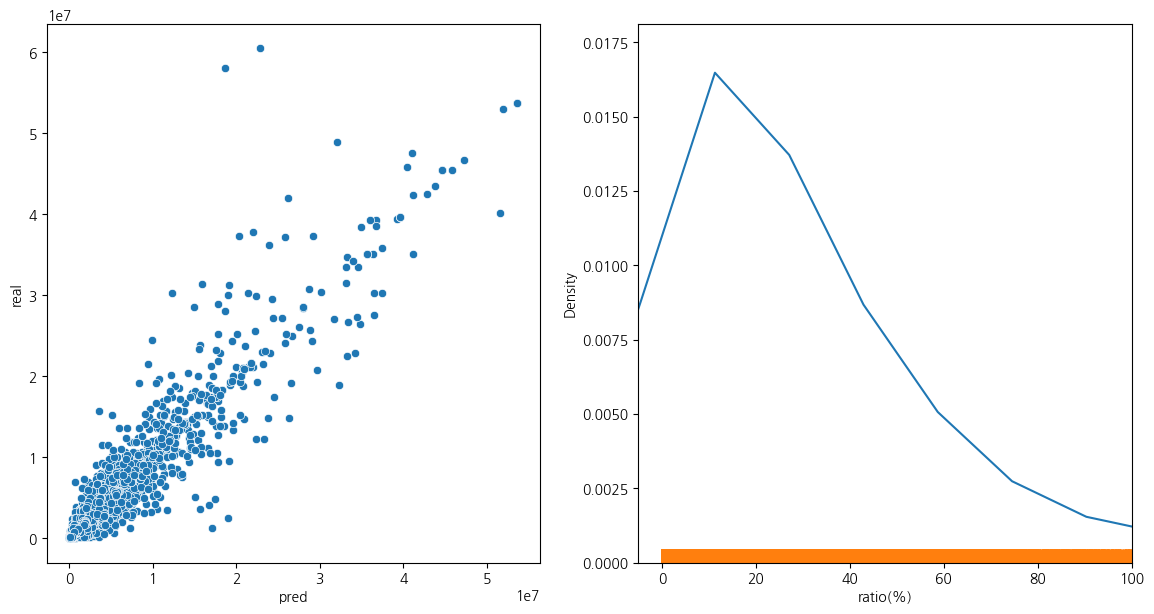

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 7))
sns.scatterplot(data=result, x='pred', y='real', ax=ax[0])
plt.xlim(-5, 100)
sns.kdeplot(result['ratio(%)'], ax=ax[1])
sns.rugplot(result['ratio(%)'], ax=ax[1])

<Axes: xlabel='ratio(%)', ylabel='Density'>

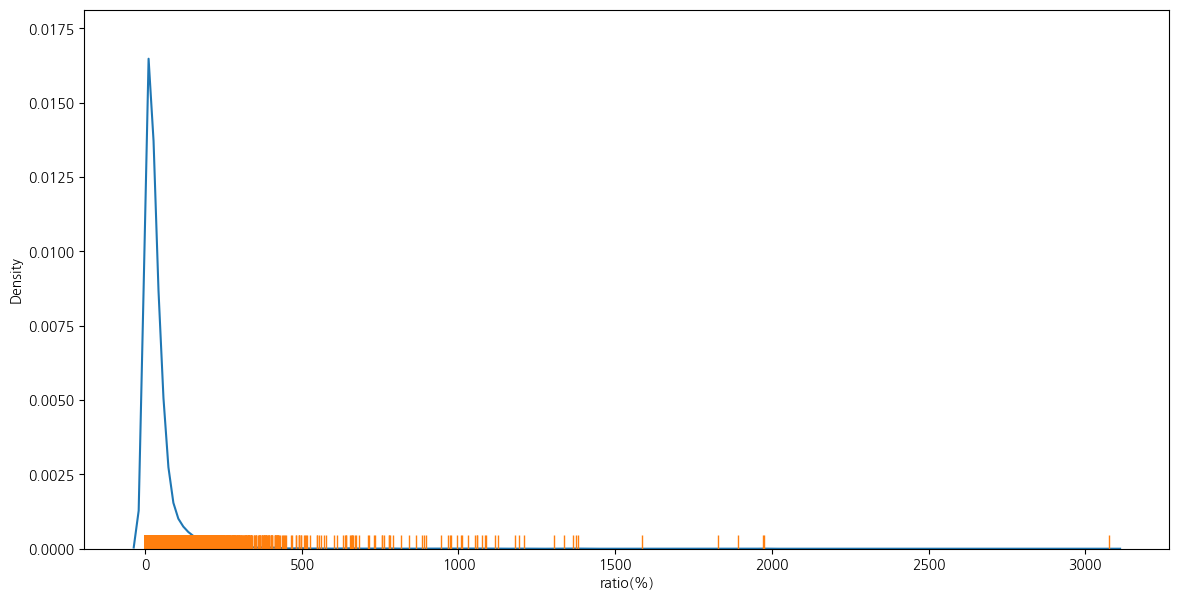

In [32]:
fig = plt.subplots(figsize=(14, 7))
sns.kdeplot(result['ratio(%)'])
sns.rugplot(result['ratio(%)'])

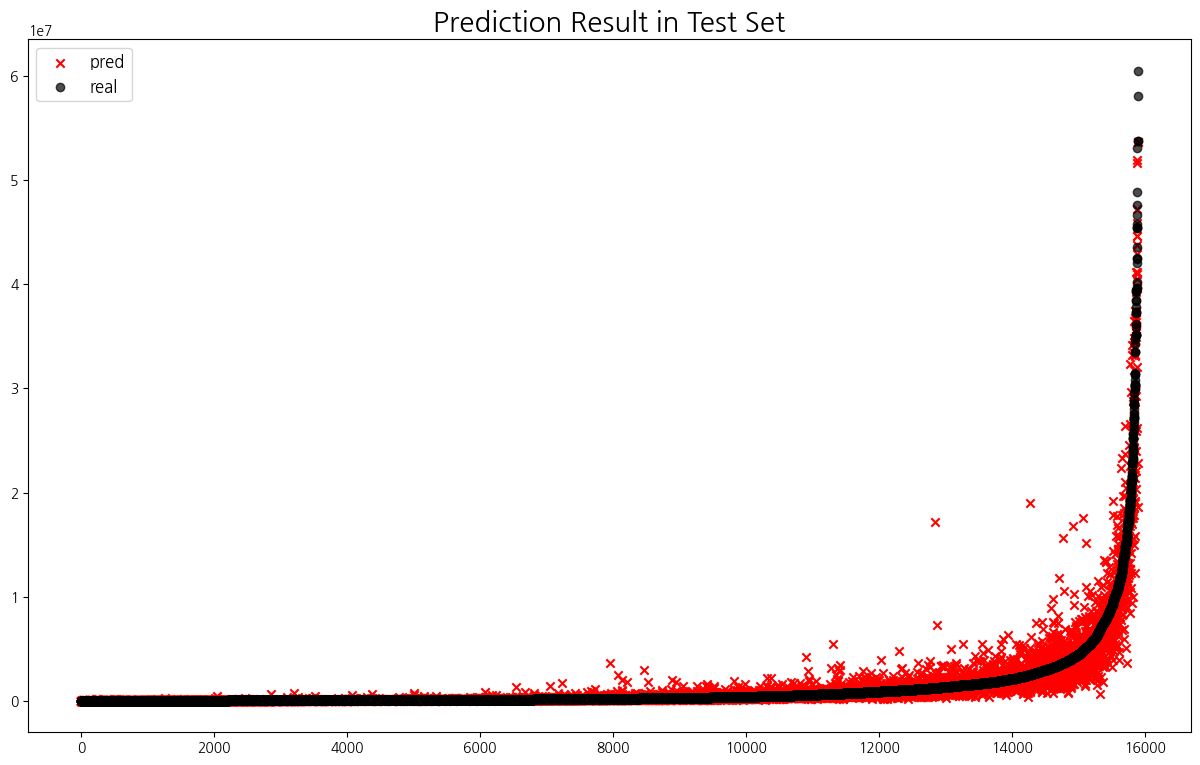

In [33]:
result = result.sort_values(by='real').reset_index(drop=True)

plt.figure(figsize=(15, 9))
plt.scatter(result.index, result['pred'], marker='x', color='r')
plt.scatter(result.index, result['real'], alpha=0.7, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['pred', 'real'], fontsize=12)
plt.show()

In [34]:
res = result

In [35]:
result = res[res["sido"] == 46]

In [36]:
print(result.sort_values('ratio(%)'))
print('ratio < 3:', len(result[result['ratio(%)'] < 3]), '/', len(result), 
    '({0:0.2f}%)'.format(len(result[result['ratio(%)'] < 3])/len(result)*100))
print('ratio < 5:', len(result[result['ratio(%)'] < 5]), '/', len(result), 
    '({0:0.2f}%)'.format(len(result[result['ratio(%)'] < 5])/len(result)*100))
print('ratio < 10:', len(result[result['ratio(%)'] < 10]), '/', len(result), 
    '({0:0.2f}%)'.format(len(result[result['ratio(%)'] < 10])/len(result)*100))

      sido        pred     real ratio(%)
11859   46   818819.19   819025     0.03
5207    46    74415.76    74529     0.15
5212    46    74415.76    74529     0.15
14572   46  3120182.50  3115225     0.16
11384   46   682790.12   683929     0.17
...    ...         ...      ...      ...
112     46    81947.38     7396  1008.00
1       46    13227.44     1024  1191.74
254     46   146428.62    10201  1335.43
247     46   146428.62    10000  1364.29
3200    46   719623.88    36100  1893.42

[842 rows x 4 columns]
ratio < 3: 66 / 842 (7.84%)
ratio < 5: 91 / 842 (10.81%)
ratio < 10: 185 / 842 (21.97%)


In [37]:
import requests
import json

# 서울 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)

In [38]:
# Load Train Dataset
DATA_PATH = "./data_Seoul.csv"
df = pd.read_csv(DATA_PATH)
# 실거래가 데이터 면적당 가격으로 환산 후 실수형 자료형으로 변경
#df["DealAmount"] = df.DealAmount.str.replace(",", "").astype("float64") * 10000 / df["LndpclAr"]
# PNU 코드 자료형 object로 변경
df["PNU"] = df["PNU"].astype("str")
df.insert(loc=1,column="Sido",value=df["PNU"].str.slice(0, 2).astype("object"))
df.insert(loc=1,column="Sigungu",value=df["PNU"].str.slice(2, 5).astype("object"))
df.insert(loc=1,column="Eupmyeondong",value=df["PNU"].str.slice(5, 8).astype("object"))
df.insert(loc=1,column="Ri",value=df["PNU"].str.slice(8, 10).astype("object"))
df.insert(loc=1,column="LandName",value=df["LdCodeNm"].str.split(" ").str.get(1))
df = df[df["Sido"] == "11"]
df.head(5)

,PNU,LandName,Ri,Eupmyeondong,Sigungu,Sido,DealMonth,LdCodeNm,RegstrSeCodeNm,Year,LndcgrCodeNm,LndpclAr,PrposAreaNm,LadUseSittnNm,TpgrphHgCodeNm,TpgrphFrmCodeNm,RoadSideCodeNm,PblntfPclnd,Tot_ppltn,Avg_age,Ppltn_dnsty,Aged_child_idx,Oldage_suprt_per,Juv_suprt_per,Tot_family,Avg_fmember_cnt,Tot_house,Corp_cnt,Tot_worker,PrposAreaDstrcCodeNm
0,1111010100100010000,종로구,00,101,110,11,1,서울특별시 종로구 청운동,일반,2023,대,15622.10,제3종전용주거지역,아파트,완경사,사다리형,소로한면,5320000,11133,43.60,4334.30,161.40,25.10,15.60,4672,2.40,3848,1444,7856,"대공방어협조구역(위탁고도:54-236m)(포함),상대보호구역(저촉),도시지역(포함)..."
1,1111010100100010001,종로구,00,101,110,11,1,서울특별시 종로구 청운동,일반,2023,도로,21.40,제3종전용주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,1567000,11133,43.60,4334.30,161.40,25.10,15.60,4672,2.40,3848,1444,7856,"대공방어협조구역(위탁고도:54-236m)(포함),상대보호구역(저촉),도시지역(포함)..."
2,1111010100100010002,종로구,00,101,110,11,1,서울특별시 종로구 청운동,일반,2023,대,20.70,제3종전용주거지역,주거나지,급경사,삼각형,맹지,2355000,11133,43.60,4334.30,161.40,25.10,15.60,4672,2.40,3848,1444,7856,"대공방어협조구역(위탁고도:54-236m)(포함),상대보호구역(저촉),도시지역(포함)..."
3,1111010100100010003,종로구,00,101,110,11,1,서울특별시 종로구 청운동,일반,2023,대,24.40,제3종전용주거지역,연립,완경사,삼각형,소로한면,5104000,11133,43.60,4334.30,161.40,25.10,15.60,4672,2.40,3848,1444,7856,"대공방어협조구역(위탁고도:54-236m)(포함),상대보호구역(저촉),도시지역(포함)..."
4,1111010100100010004,종로구,00,101,110,11,1,서울특별시 종로구 청운동,일반,2023,도로,48.90,제3종전용주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,1828000,11133,43.60,4334.30,161.40,25.10,15.60,4672,2.40,3848,1444,7856,"대공방어협조구역(위탁고도:54-236m)(포함),상대보호구역(저촉),도시지역(포함)..."


In [45]:
df_folium = pd.DataFrame(columns = ["Name", "Price"])
test_df = pd.DataFrame(np.zeros((len(df), len(test_x.columns))), columns=test_x.columns)

for i in range(len(df)):
    for c in test_x.columns:
        if c in df.columns:
            test_df.loc[i, c] = df.loc[i, c]
        else:
            if "_" in c:
                if c == str(c.split("_")[0]) + "_" + str(df.loc[i, c.split("_")[0]]):
                    test_df.loc[i, c] = 1
    
    print("\r{:5d} / {:5d}".format(i, len(df)), end="")


31216 / 31217

In [46]:
pred = model.predict(test_df) ** 2
test_df

,DealMonth,Year,PblntfPclnd,Tot_ppltn,Avg_age,Ppltn_dnsty,Aged_child_idx,Oldage_suprt_per,Juv_suprt_per,Tot_family,Avg_fmember_cnt,Tot_house,Corp_cnt,Tot_worker,Sido_11,Sido_26,Sido_27,Sido_28,Sido_29,Sido_30,Sido_31,Sido_36,Sido_41,Sido_44,Sido_45,Sido_46,RegstrSeCodeNm_산,RegstrSeCodeNm_일반,LndcgrCodeNm_공원,LndcgrCodeNm_공장용지,LndcgrCodeNm_과수원,LndcgrCodeNm_구거,LndcgrCodeNm_답,LndcgrCodeNm_대,LndcgrCodeNm_도로,LndcgrCodeNm_목장용지,LndcgrCodeNm_묘지,LndcgrCodeNm_사적지,LndcgrCodeNm_수도용지,LndcgrCodeNm_양어장,LndcgrCodeNm_염전,LndcgrCodeNm_유원지,LndcgrCodeNm_유지,LndcgrCodeNm_임야,LndcgrCodeNm_잡종지,LndcgrCodeNm_전,LndcgrCodeNm_제방,LndcgrCodeNm_종교용지,LndcgrCodeNm_주유소용지,LndcgrCodeNm_주차장,LndcgrCodeNm_창고용지,LndcgrCodeNm_철도용지,LndcgrCodeNm_체육용지,LndcgrCodeNm_하천,LndcgrCodeNm_학교용지,PrposAreaNm_개발제한구역,PrposAreaNm_계획관리지역,PrposAreaNm_관리지역,PrposAreaNm_근린상업지역,PrposAreaNm_농림지역,PrposAreaNm_보전관리지역,PrposAreaNm_생산관리지역,PrposAreaNm_생산녹지지역,PrposAreaNm_용도미지정,PrposAreaNm_유통상업지역,PrposAreaNm_일반공업지역,PrposAreaNm_일반상업지역,PrposAreaNm_자연녹지지역,PrposAreaNm_전용공업지역,PrposAreaNm_제1종전용주거지역,PrposAreaNm_제2종일반주거지역,PrposAreaNm_제2종전용주거지역,PrposAreaNm_제3종일반주거지역,PrposAreaNm_준공업지역,PrposAreaNm_준주거지역,PrposAreaNm_중심상업지역,LadUseSittnNm_골프장 대중제,LadUseSittnNm_골프장 회원제,LadUseSittnNm_공업기타,LadUseSittnNm_공업나지,LadUseSittnNm_공업용,LadUseSittnNm_공원등,LadUseSittnNm_과수원,LadUseSittnNm_다세대,LadUseSittnNm_단독,LadUseSittnNm_답,LadUseSittnNm_답기타,LadUseSittnNm_도로등,LadUseSittnNm_목장용지,LadUseSittnNm_상업기타,LadUseSittnNm_상업나지,LadUseSittnNm_상업용,LadUseSittnNm_아파트,LadUseSittnNm_업무용,LadUseSittnNm_여객자동차터미널,LadUseSittnNm_연립,LadUseSittnNm_유원지,LadUseSittnNm_임야기타,LadUseSittnNm_자연림,LadUseSittnNm_전,LadUseSittnNm_전기타,LadUseSittnNm_조림,LadUseSittnNm_주거기타,LadUseSittnNm_주거나지,LadUseSittnNm_주상기타,LadUseSittnNm_주상나지,LadUseSittnNm_주상용,LadUseSittnNm_토지임야,LadUseSittnNm_하천등,TpgrphHgCodeNm_고지,TpgrphHgCodeNm_급경사,TpgrphHgCodeNm_완경사,TpgrphHgCodeNm_저지,TpgrphHgCodeNm_지정되지않음,TpgrphHgCodeNm_평지,TpgrphFrmCodeNm_가로장방,TpgrphFrmCodeNm_부정형,TpgrphFrmCodeNm_사다리형,TpgrphFrmCodeNm_삼각형,TpgrphFrmCodeNm_세로장방,TpgrphFrmCodeNm_역삼각형,TpgrphFrmCodeNm_자루형,TpgrphFrmCodeNm_정방형,TpgrphFrmCodeNm_지정되지않음,RoadSideCodeNm_광대로한면,RoadSideCodeNm_광대세각,RoadSideCodeNm_광대소각,RoadSideCodeNm_맹지,RoadSideCodeNm_세로각지(가),RoadSideCodeNm_세로각지(불),RoadSideCodeNm_세로한면(가),RoadSideCodeNm_세로한면(불),RoadSideCodeNm_소로각지,RoadSideCodeNm_소로한면,RoadSideCodeNm_중로각지,RoadSideCodeNm_중로한면,RoadSideCodeNm_지정되지않음
0,1.00,2023.00,5320000.00,11133.00,43.60,4334.30,161.40,25.10,15.60,4672.00,2.40,3848.00,1444.00,7856.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,1.00,2023.00,1567000.00,11133.00,43.60,4334.30,161.40,25.10,15.60,4672.00,2.40,3848.00,1444.00,7856.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,1.00,2023.00,2355000.00,11133.00,43.60,4334.30,161.40,25.10,15.60,4672.00,2.40,3848.00,1444.00,7856.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,

In [47]:
for i in range(len(df)):
    df_folium.loc[i] = [df.loc[i, "LandName"], pred[i]]
    print("\r{:5d} / {:5d}".format(i, len(df)), end="")

In [48]:
df_folium

,Name,Price
31216,종로구,21591542.00
0,종로구,20859522.00
1,종로구,16749999.00
2,종로구,12908246.00
3,종로구,22159788.00
...,...,...
31211,종로구,21591542.00
31212,종로구,16241126.00
31213,종로구,19710270.00
31214,종로구,21591542.00


In [50]:
print(df_folium.groupby("Name")["Price"].mean())

Name
종로구    20749310.00
Name: Price, dtype: float32


In [58]:
import pymysql 

conn = pymysql.connect(host='localhost', user='landprice', password='landprice123', db="landprice_db", charset='utf8') 
cursor = conn.cursor() 

sql = "SELECT * FROM Seoul_LandInfo" 

cursor.execute(sql) 
res = cursor.fetchall()
conn.commit() 
conn.close() 

In [71]:
pnu = {}
with open('/home/students/cs/202120990/land-price-pred/data/pnu_code.csv', 'r') as pnu_f:
    pnu_reader = pnu_f.readlines()
for line in pnu_reader:
    pnu[line.split(",")[0][0:5]] = line.split(",")[2]

In [79]:
df_folium = pd.DataFrame(columns = ["Name", "Price"])

for i in range(len(res)):
    df_folium.loc[i] = [pnu[res[i][0][0:5]], res[i][2]]
    print("\r{:5d} / {:5d}".format(i, len(df)), end="")

902471 / 31217

KeyError: 'pnu'

In [76]:
pnu[res[88000][0][0:5]]

'용산구'

In [77]:
len(res)

902473

In [80]:
import folium

m = folium.Map(
    location=[37.559819, 126.963895],
    zoom_start=11, 
    tiles='cartodbpositron'
)

folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(m)

seoul_group_data = df_folium.groupby("Name")["Price"].mean()

folium.Choropleth(geo_data=seoul_geo,
             data=seoul_group_data, 
             fill_color='YlOrRd', # 색상 변경도 가능하다
             fill_opacity=0.5,
             line_opacity=0.2,
             key_on='properties.name',
             legend_name="지역구별 토지 가격"
).add_to(m)

In [81]:
m

In [82]:
seoul_group_data

Name
강남구     7024372.08
강동구     4863751.16
강북구     5120910.76
강서구     5277563.43
관악구     5312503.98
광진구     6310094.63
구로구     5112095.38
금천구     6955209.05
노원구     5008445.11
도봉구     4284667.25
동대문구    5477823.38
동작구     5877139.49
마포구     7003813.76
서대문구    5276479.98
서초구     5211542.08
성동구     5466707.44
성북구     4254701.64
송파구     5872098.17
양천구     5098967.89
영등포구    6575487.31
용산구     5727404.82
은평구     5201128.59
종로구     5912625.79
중구      7567494.20
중랑구     4391599.77
Name: Price, dtype: float64